### Refs
- [RDKit Documentation](https://www.rdkit.org/docs/GettingStartedInPython.html)
- [PubChem](https://pubchem.ncbi.nlm.nih.gov/) - find SDF files for molecules
- [YouTube Tutorial](https://www.youtube.com/watch?v=NozaWUkJ3YM)

### Workflow Suggestions
> After modifying classes from `src` directory, **Restart NoteBook Kernel** is required 
- Recommended action after changing files in `src`: Restart -> Run All

## Imports

In [5]:
from src.core.compound import MBCompound
from src.loader import MBLoader
from src.utils.renderer import Renderer
from src.utils.ui import Theme
from src import DIAMAG_COMPOUND_ATOMS_SUBDIR


## RDkit Diamag Calcs


In [ ]:
from __future__ import annotations
from dataclasses import dataclass
from collections import Counter, defaultdict
from typing import Iterable

@dataclass(frozen=True, slots=True)
class BondMatchCandidate:
    formula: str
    prio: int
    atoms: tuple[int, ...]   # zawsze tuple[int] dla deterministyki

    @property
    def key_self(self) -> tuple[int, tuple[int, ...]]:
        # większe fragmenty pierwsze, potem stabilnie po indeksach
        return (-len(self.atoms), self.atoms)

def resolve_candidates(
    candidates: list[BondMatchCandidate],
) -> tuple[
    dict[str, list[tuple[int, ...]]],  # final_hits_by_formula
    Counter,                           # matches_counter
    dict[str, set[int]],               # groups_atoms
    set[int],                          # atoms_to_highlight
]:
    # A) self-overlap w obrębie formuły
    by_formula: dict[str, list[BondMatchCandidate]] = defaultdict(list)
    for c in candidates:
        by_formula[c.formula].append(c)

    cleaned: dict[str, list[tuple[int, ...]]] = {}
    for formula, lst in by_formula.items():
        lst_sorted = sorted(lst, key=lambda c: c.key_self)
        used_local: set[int] = set()
        kept_atoms: list[tuple[int, ...]] = []
        for c in lst_sorted:
            if any(a in used_local for a in c.atoms):
                continue
            kept_atoms.append(c.atoms)
            used_local.update(c.atoms)
        cleaned[formula] = kept_atoms

    # B) cross-formula po priorytecie (większy prio wygrywa)
    formulas_sorted = sorted(
        cleaned.keys(),
        key=lambda f: (-max(c.prio for c in by_formula[f]), f),
    )

    used_global: set[int] = set()
    final_hits_by_formula: dict[str, list[tuple[int, ...]]] = {}

    for f in formulas_sorted:
        kept: list[tuple[int, ...]] = []
        for atoms in cleaned[f]:
            if any(a in used_global for a in atoms):
                continue
            kept.append(atoms)
            used_global.update(atoms)
        final_hits_by_formula[f] = kept

    # outputs
    matches_counter: Counter[str] = Counter()
    groups_atoms: dict[str, set[int]] = defaultdict(set)
    atoms_to_highlight: set[int] = set()

    for f, hits in final_hits_by_formula.items():
        if not hits:
            continue
        matches_counter[f] += len(hits)
        for h in hits:
            groups_atoms[f].update(h)
            atoms_to_highlight.update(h)

    return final_hits_by_formula, matches_counter, groups_atoms, atoms_to_highlight

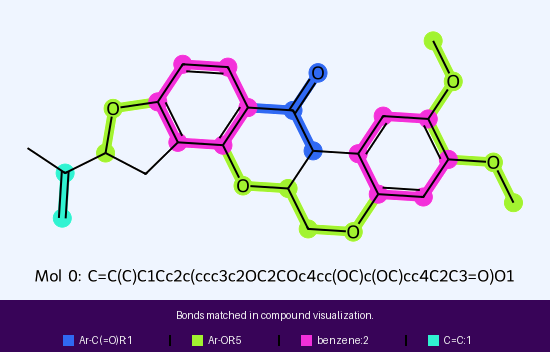

In [7]:
from collections import Counter
from typing import DefaultDict
from collections import defaultdict

from src.constants.bond_types import RELEVANT_BOND_TYPES
from src.loader import MBLoader, MBMolecule
from tests.core.bond_match.bond_match_test_data import BOND_MATCH_TEST_CASES

failures: list[str] = []

mols: list[MBMolecule] = []
highlightAtomLists: list[list[int]] = []
highlightAtomGroupsPerMol: list[dict[str, list[int]]] = []
matches_counters: list[Counter[str]] = []

for idx, bond_type_test in enumerate(BOND_MATCH_TEST_CASES):
    matches_counter: Counter[str] = Counter()
    mol: MBMolecule = MBLoader.MolFromSmiles(smiles=bond_type_test.SMILES)
    mols.append(mol)

    # Collect highlight atoms for this molecule (flat union) + per-formula atom groups (NEW)
    atoms_to_highlight: set[int] = set()
    groups_atoms: dict[str, set[int]] = defaultdict(set)  # formula -> atoms

    candidates: list[BondMatchCandidate] = []

    for bt in RELEVANT_BOND_TYPES:
        hits = mol.GetSubstructMatches(smarts=bt.SMARTS)
        if not hits:
            continue

        prio = int(getattr(bt, "prio", 0))
        for h in hits:
            candidates.append(
                BondMatchCandidate(
                    formula=bt.formula,
                    prio=prio,
                    atoms=tuple(int(x) for x in h),
                )
            )

    # post-processing: self-overlap + priorytety
    final_hits_by_formula, matches_counter, groups_atoms, atoms_to_highlight = resolve_candidates(candidates)

    # renderer inputs (tak jak wcześniej)
    highlightAtomLists.append(sorted(atoms_to_highlight))
    highlightAtomGroupsPerMol.append({k: sorted(v) for k, v in groups_atoms.items()})
    matches_counters.append(matches_counter)

    x = 1

# Render: highlightAtomLists length == len(mols)
display(
    Renderer(Theme.LoFi).GetMoleculesGridImg(
        mols=[m.ToRDKit() for m in mols],
        highlightAtomLists=highlightAtomLists,
        highlightAtomGroupsPerMol=highlightAtomGroupsPerMol,
        matchesCountersPerMol=matches_counters,
        size=(550, 300),
        mols_per_row=1,
        label="Bonds matched in compound visualization.",
        showLegend=True,
    )
)


### Aromaticity check

In [8]:
from rdkit.Chem import MolFromSmiles
from rdkit import Chem

mol = MolFromSmiles("C1=COC=CC1=O")
mol.GetAtomWithIdx(3).GetIsAromatic()

True